## Creating a graph from text data and adding the time activity
Looking at the neighbours of a selected word

### Loading the text data

In [1]:
import pandas as pd
import itertools
import numpy as np

In [2]:
graph_data_path = '/home/benjamin/Documents/memetracker/Data/graph/'
pickle_data_path = '/home/benjamin/Documents/memetracker/Data/pickle/'
series_name = 'LBDL'
series_name = 'marseille'
pickle_file = pickle_data_path+series_name+'_texts'+'.pkl'
vocab_file = pickle_data_path+series_name+'_vocab_bow'+'.pkl'
tfidf_file = pickle_data_path+series_name+'_vocab_tfidf'+'.pkl'

In [3]:
text_data = pd.read_pickle(pickle_file)
vocab_data = pd.read_pickle(vocab_file)
tfidf_data = pd.read_pickle(tfidf_file)

In [4]:
# create the set of most used words
#nb_words = 200
#word_set = set(tfidf_data.words[0:nb_words])

### Creating the graph

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

In [6]:
G = nx.DiGraph()

In [ ]:
def control_graph(G,word1,word2,list_forbidden_words):
    # Control the degree of a word1 and word2
    # if it is above the threshold, the words are removed from the graph
    # a high degree means a node connected to many different words
    # and put in the list of forbidden words
    # Return:
    # forbidden_word (bool): True if one of the words is in the list
    # list_forbidden_words  the list of forbidden words increased in word1 or word2 are now forbidden
    
    words = [word1,word2]
    threshold = 50
    # control the degree
    for word in words:
        if G.has_node(word):
            degree = G.degree(word)
            if degree > threshold:
                list_forbidden_words.append(word)
                G.remove_node(word)
        
    # Check if in the list of forbidden words
    if (set(words)&set(list_forbidden_words)):
        forbidden_word = True
    else:
        forbidden_word = False
    return forbidden_word,list_forbidden_words

In [ ]:
# for each text, create node for each keyword and connect to its following word 
list_forbidden_words = []
for text in text_data.filtered_text:
    textlist = str(text).split()
    for idx,word in enumerate(textlist):
        #print(idx)
        if (idx+1)<len(textlist):
            next_word = textlist[idx+1]
            # Firs control if the words follow the graph construction rules
            forbidden_word, list_forbidden_words = control_graph(G,word,next_word,list_forbidden_words)
            if  not forbidden_word:
                # Adding the nodes
                if not G.has_node(word):
                    G.add_node(word,name=word)
                if not G.has_node(next_word):
                    G.add_node(next_word,name=next_word)
                # Adding an edge
                if G.has_edge(word,next_word):
                    # we added this one before, just increase the weight by one
                    G[word][next_word]['weight'] += 1
                else:
                    # new edge. add with weight=1
                    G.add_edge(word, next_word, weight=1)


In [ ]:
len(list_forbidden_words)

In [ ]:
G.size()

In [ ]:
# Reduce the graph if the node weighted degree is too small
for u in G.nodes():
    if G.degree(u,weight='weight')<10:
        G.remove_node(u)

In [ ]:
G.size()

In [ ]:
# Write the graph to a json file
from networkx.readwrite import json_graph
datag = json_graph.node_link_data(G)
import json
s = json.dumps(datag)
datag['links'] = [
        {
            'source': datag['nodes'][link['source']]['id'],
            'target': datag['nodes'][link['target']]['id'],
            'weight': link['weight']
        }
        for link in datag['links']]
s = json.dumps(datag)
with open("viz/graphM2.json", "w") as f:
    f.write(s)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
#degreeDic = G.degree(weight='weight')
degreeDic = G.degree()
degreeslist = list(degreeDic.values())
plt.hist(degreeslist,bins=35)
plt.show()

In [ ]:
DF = pd.DataFrame.from_dict(degreeDic,orient='index')
DF.columns = ['Degree']

In [ ]:
DF.sort_values(by='Degree', axis=0, ascending=False)

In [ ]:
degreeDic = G.degree(weight='weight')
#degreeDic = G.degree()
degreeslist = list(degreeDic.values())
plt.hist(degreeslist,bins=100)
plt.show()

In [ ]:
G.size()

In [ ]:
DF = pd.DataFrame.from_dict(degreeDic,orient='index')
DF.columns = ['Degree']

In [ ]:
DF.sort_values(by='Degree', axis=0, ascending=False)

### Time evaluation

In [7]:
def time_slice(df,start_date,end_date):
    # df must have a column 'date
    # date are in datetime format
    mask = (df['date'] > start_date) & (df['date'] <= end_date)
    df_slice = df.loc[mask]
    return df_slice

### Create the multilayer graph

In [8]:
def layer_graph(df,timestamp):
# for each text, create node for each keyword and connect to its following word 
    timestamp_str = '_'+timestamp.strftime("%Y-%m-%d")
    G = nx.DiGraph()
    for row in df.itertuples():
        text = row.filtered_text
        #text = row.text
        textlist = str(text).split()
        for idx,word in enumerate(textlist):
            #print(idx)
            if (idx+1)<len(textlist):
                next_word = textlist[idx+1]
                word_id = word+timestamp_str
                next_word_id = next_word+timestamp_str
                # Adding the nodes
                if not G.has_node(word_id):
                    G.add_node(word_id,name=word,timestamp=timestamp)
                if not G.has_node(next_word_id):
                    G.add_node(next_word_id,name=next_word,timestamp=timestamp)
                # Adding an edge
                if G.has_edge(word_id,next_word_id):
                    # we added this one before, just increase the weight by one
                    G[word_id][next_word_id]['weight'] += 1
                    tseries = G[word_id][next_word_id]['time_series']
                    #print(tseries)
                    #print(type(tseries))
                    #print(type(row.date))
                    tseries.append(row.date)
                    #.append(row.date.strftime('%Y-%m-%d'))
                    G[word_id][next_word_id]['time_series'] = tseries
                else:
                    # new edge. add with weight=1
                    new_list = []
                    new_list.append(row.date)
                    G.add_edge(word_id, next_word_id, weight=1,time_series=new_list)
    return G

In [9]:
def drop_edges(G,threshold=4):
    for u,v,a in G.edges(data=True):
        if a['weight']<threshold:
            G.remove_edge(u,v)
    return G

In [10]:
def get_node_name(node):
    # return the name before the date (separated by a '_')
    idx = node.rfind('_')
    return node[:idx]

In [11]:
def connect_layer(H,G_old,G):
    old_nodes = G_old.nodes()
    for new_node in G.nodes():
        new_node_name = get_node_name(new_node)
        for old_node in G_old.nodes():
            old_node_name = get_node_name(old_node)
            if new_node_name == old_node_name:
                H.add_edge(old_node,new_node,weight=100,label='interlayer')
    return H

In [12]:
def range_date(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta

In [13]:
def date_to_int(date, start, end):
    # return an int in[0,1]
    # from a date between [start, end]
    from datetime import timedelta
    list_dates =[n for n in range_date(start, end+timedelta(days=1), timedelta(days=1))]
    idx = list_dates.index(date)
    if (len(list_dates)-1)>0:
        value = idx/(len(list_dates)-1)
    else:
        value = 0
    return value

In [14]:
def find_dates(G):
    date_list = [ m for n,m in nx.get_node_attributes(G,'timestamp').items()]
    start_date = min(date_list)
    end_date = max(date_list)
    return start_date,end_date

In [15]:
def add_relative_date(G):
    import datetime
    if nx.number_of_nodes(G)>0:
        date_list = [ datetime.datetime.strptime(m,"%d-%m-%Y") for n,m in nx.get_node_attributes(G,'start_time').items()]
        start_date = min(date_list)
        end_date = max(date_list)
        for (node,props) in G.nodes(data=True):
            G.node[node]['color_rel'] = date_to_int(datetime.datetime.strptime(props['start_time'],"%d-%m-%Y"),start_date,end_date)
    return G

In [16]:
def compress_component(G,threshold):
    from collections import Counter
    # nodes
    node_list = [get_node_name(node) for node in G.nodes()] # name from id
    nodes_dic = Counter(node_list)
    nodes_t = [(name,{'nb_occur':nb_occur}) for (name,nb_occur) in nodes_dic.items() if nb_occur>threshold]
    node_list = [name for (name,prop) in nodes_t]
    if len(node_list)>0:
        #node time
        node_data = G.nodes(data=True)
        #edges
        edge_list = [(get_node_name(u),get_node_name(v)) for (u,v) in G.edges()]
        edge_list = [(u,v) for (u,v) in edge_list if (u in node_list and v in node_list)]
        edge_list = [(u,v) for (u,v) in edge_list if not (u == v)]
        #graph
        G2 = nx.DiGraph()
        G2.graph['start_date']=G.graph['start_date'].strftime("%d-%m-%Y")
        G2.graph['end_date']=G.graph['end_date'].strftime("%d-%m-%Y")
        G2.add_nodes_from(nodes_t)
        G2.add_edges_from(edge_list)
        #G2 = max(nx.weakly_connected_component_subgraphs(G2), key=len)
        G2.remove_nodes_from(nx.isolates(G2))
        # time property
        node_data = G.nodes(data=True)
        start_date,end_date = find_dates(G)
        #print(start_date,end_date)
        for node in G2.nodes():
            time_list = []
            for (G_node,properties) in G.nodes(data=True):
                if node in G_node:
                    time_list.append(properties['timestamp'])
            time_list.sort()
            G2.node[node]['start_time']=time_list[0].strftime("%d-%m-%Y")
            G2.node[node]['name'] = node
            G2.node[node]['color'] = date_to_int(time_list[0],G.graph['start_date'],G.graph['end_date'])
            #print(date_to_int(time_list[0],start_date,end_date))
            G2.node[node]['color_rel_full'] = date_to_int(time_list[0],start_date,end_date)
            #G2.node[node]['time_length'] = len(time_list)
            # relabel the nodes to take into account the first time stamp
        G2 = add_relative_date(G2)
        #[ print(props) for(name,props) in G2.nodes(data=True)]
        dic_of_names = {name:name+'_'+props['start_time'] for(name,props) in G2.nodes(data=True) }
        G3 = nx.relabel_nodes(G2,dic_of_names)
        return G3
    else:
        return nx.DiGraph()

### Create the multilayer graph of activity

In [17]:
import datetime
from dateutil.relativedelta import relativedelta
base = pd.datetime(2016,1,1)
#three_mon_rel = relativedelta(months=3)
month_list_2015 = [base + relativedelta(month=x) for x in range(1, 13)]

In [47]:
month = 5
day_list = [month_list_2015[month-1]+datetime.timedelta(days=n) for n in range(31) 
            if month_list_2015[month-1]+datetime.timedelta(days=n)<month_list_2015[month]]

In [48]:
H = nx.DiGraph(start_date=day_list[0],end_date=day_list[-1])
#start_date = pd.datetime(2015,1,1)
#increment = datetime.timedelta(days=1)
#end_date = start_date + increment
weight_threshold = 50
G_old = nx.DiGraph()
#start_date = month_list_2015[0]
#end_date = month_list_2015[1]
for idx,day in enumerate(day_list):
    # Compute the graph layer
    data = time_slice(text_data,day,day+datetime.timedelta(days=1))
    G = layer_graph(data,day)
    G = drop_edges(G,weight_threshold)
    color = idx/len(day_list)
    nx.set_node_attributes(G,'color',color)
    # Add the layer to the global graph
    H.add_nodes_from(G.nodes(data=True))
    H.add_edges_from(G.edges(data=True))
    # Connect the layer
    H = connect_layer(H,G_old,G)
    ## update the date and loop
    #start_date += increment
    #end_date += increment
    G_old = G


In [49]:
print('Nb of edges: {}, nb of nodes: {}.'.format(H.size(),len(H.nodes())))

Nb of edges: 14527, nb of nodes: 64422.


In [50]:
H.remove_nodes_from(nx.isolates(H))

In [51]:
print('Nb of edges: {}, nb of nodes: {}.'.format(H.size(),len(H.nodes())))

Nb of edges: 14527, nb of nodes: 21578.


### Study of the largest component

In [52]:
#Gc = max(nx.weakly_connected_component_subgraphs(H), key=len)
#G2 = compress_component(Gc,2)

### Compress all the components

In [53]:
G_all = nx.DiGraph()
for c in nx.weakly_connected_component_subgraphs(H):
    cc = compress_component(c,1)
    G_all = nx.compose(G_all,cc)

In [54]:
#[len(c) for c in nx.weakly_connected_component_subgraphs(H)]

In [55]:
G_all.size()

660

### Visualize the compressed components

In [44]:
import matplotlib.pyplot as plt

In [ ]:
nx.draw_spring(G_all)
plt.show()

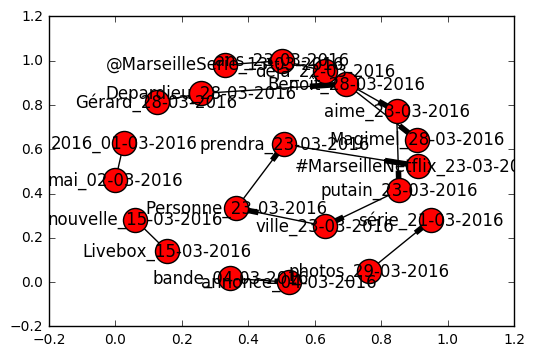

In [45]:
nx.draw_networkx(G_all)
plt.show()

### Save the compressed components

In [56]:
from networkx.readwrite import json_graph
import json
json_filename = 'ccomponent.json'
data = json_graph.node_link_data(G_all)
#,attrs={'source': 'source', 'target': 'target','key': 'key', 'id': 'id', 'nb_occur':'nb_occur','start_time':'start_time','name':'name', 'color':'color'})#,'time_length':'time_length'})
data['links'] = [
        {
            'source': data['nodes'][link['source']]['id'],
            'target': data['nodes'][link['target']]['id']
        }
        for link in data['links']]
s = json.dumps(data)
with open("./viz/"+json_filename, "w") as f:
    f.write(s)

In [ ]:
# run a websever in the folder where the json file has been saved
# python3 -m http.server --bind 127.0.0.1 8008

import webbrowser
url = 'http://localhost:8008/forcegraphmeme.html'+'?'+'file='+json_filename
#webbrowser.open_new_tab(url)
webbrowser.open_new(url)

In [57]:
G_all.nodes()

['Batshuayi_13-05-2016',
 'faim_13-05-2016',
 'comité_13-05-2016',
 'seul_13-05-2016',
 'proximité_13-05-2016',
 'braqueur_13-05-2016',
 'Interdiction_13-05-2016',
 'partir_13-05-2016',
 'pompier_13-05-2016',
 'Parc_13-05-2016',
 'finit_23-05-2016',
 'série_01-05-2016',
 'stupéfiants_24-05-2016',
 'Opéra_13-05-2016',
 'Vente_13-05-2016',
 'jamais_13-05-2016',
 'minutes_13-05-2016',
 'Depardieu_13-05-2016',
 'Netflix_01-05-2016',
 'loin_13-05-2016',
 'poumon_13-05-2016',
 'départ_13-05-2016',
 'Serre_13-05-2016',
 'clichée_13-05-2016',
 'mucoviscidose_13-05-2016',
 'épisode_13-05-2016',
 'joue_13-05-2016',
 'motion_13-05-2016',
 'Allison_13-05-2016',
 'cartes_13-05-2016',
 'zone_13-05-2016',
 'opérateur_13-05-2016',
 'Naturavignon_13-05-2016',
 'annonce_13-05-2016',
 'Coupe_13-05-2016',
 'deuxième_13-05-2016',
 'gare_13-05-2016',
 'bio_13-05-2016',
 'plein_05-05-2016',
 'convoitée_13-05-2016',
 'drogue_13-05-2016',
 'the_13-05-2016',
 'Mission_13-05-2016',
 'vidéo_13-05-2016',
 'groupe_